In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image


In [2]:
data_dir = 'images/'

data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 160358 files belonging to 145 classes.


In [3]:
datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split = 0.2)

In [4]:
height = 228
width = 228
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

In [5]:
train_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

val_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 128255 images belonging to 145 classes.
Found 32031 images belonging to 145 classes.


In [6]:
num_classes = len(data.class_names)
print('.... Number of Classes : {0} ....'.format(num_classes))

.... Number of Classes : 145 ....


2023-07-13 18:56:40.592385: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


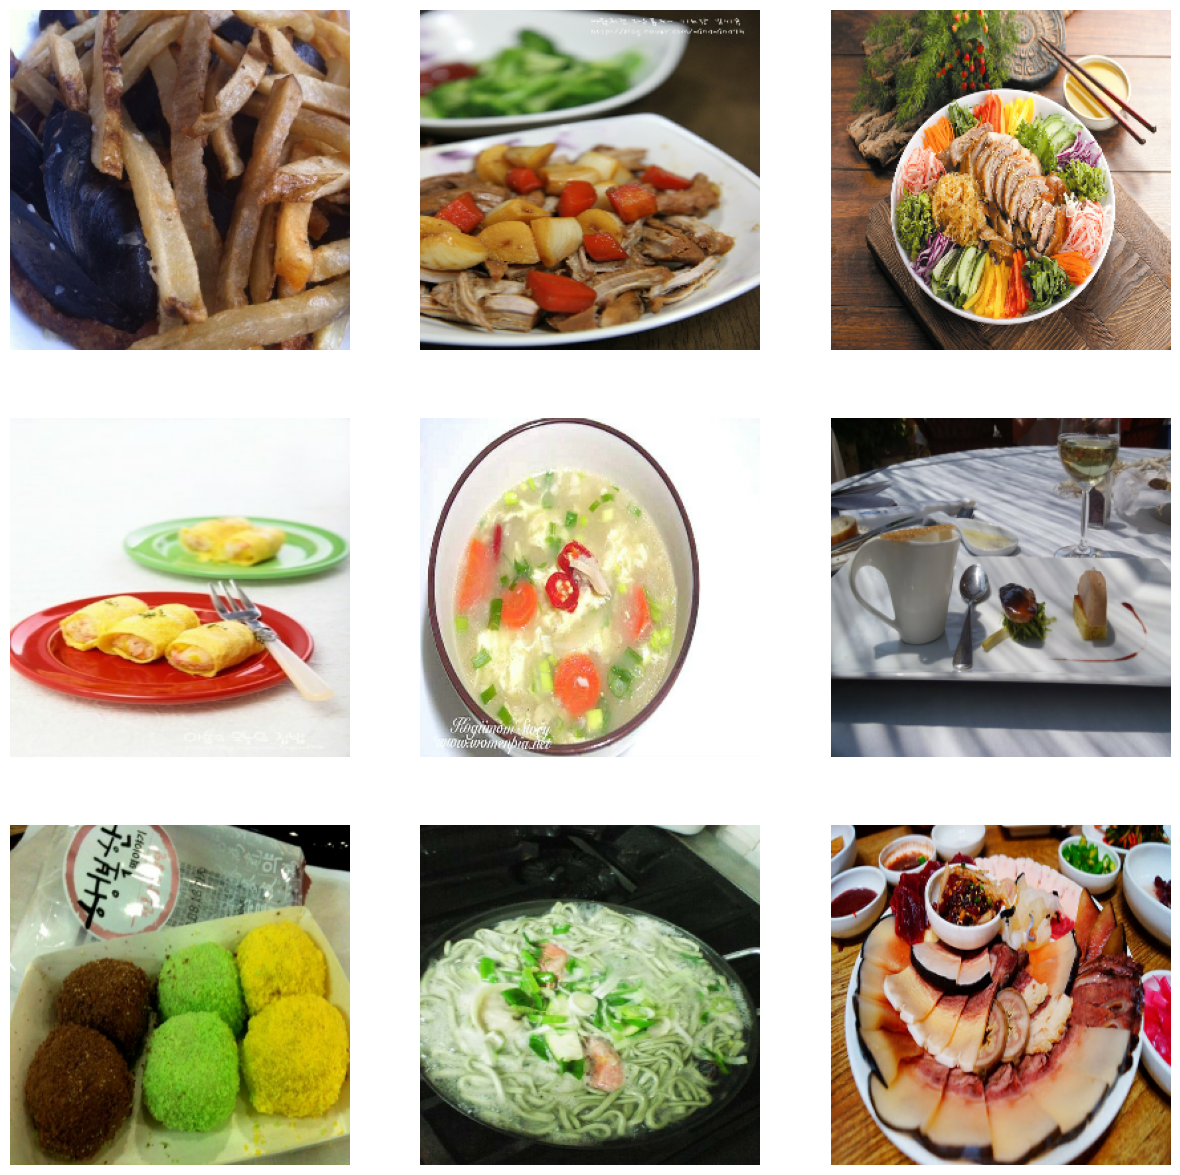

In [7]:
def show_img(data):
    plt.figure(figsize=(15,15))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

show_img(data)

training model


In [8]:
# load pre-trained InceptionV3
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

In [9]:
x = pre_trained.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs = pre_trained.input, outputs = predictions)
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 228, 228, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 113, 113, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 113, 113, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
STEP_SIZE_VALID = val_data.n // val_data.batch_size
history = model.fit_generator(train_data,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_data,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 50,
                    verbose = 1)

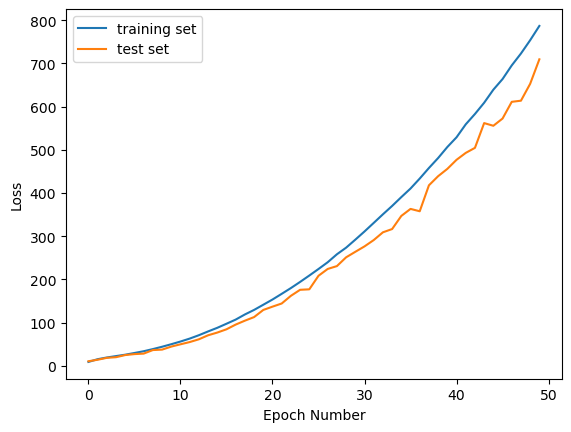

In [78]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

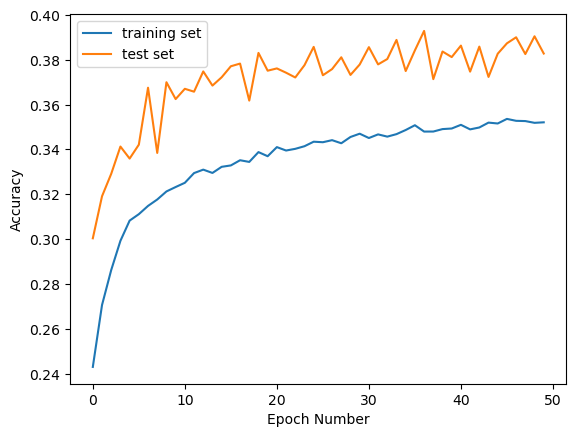

In [79]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

In [81]:
model_name = 'food_recognition_inceptionV3+korea_145class.h5'
model.save(model_name, save_format='h5')

In [82]:
class_map = train_data.class_indices
classes = []
for key in class_map.keys():
    classes.append(key)
print(class_map)

{'가리비': 0, '가지볶음': 1, '간장게장': 2, '갈비구이': 3, '갈비찜': 4, '갈비탕': 5, '갈치구이': 6, '갈치조림': 7, '감자전': 8, '감자조림': 9, '감자채볶음': 10, '감자탕': 11, '감자튀김': 12, '갓김치': 13, '건새우볶음': 14, '경단': 15, '계란국': 16, '계란말이': 17, '계란찜': 18, '계란후라이': 19, '고등어구이': 20, '고등어조림': 21, '고추튀김': 22, '곰탕_설렁탕': 23, '곱창구이': 24, '곱창전골': 25, '구운 연어': 26, '굴': 27, '김밥': 28, '김치볶음밥': 29, '김치전': 30, '김치찌개': 31, '깍두기': 32, '깻잎장아찌': 33, '꼬막찜': 34, '꽁치조림': 35, '꽈리고추무침': 36, '꿀떡': 37, '나초': 38, '누룽지': 39, '닭갈비': 40, '닭볶음탕': 41, '당근케익': 42, '도넛': 43, '도라지무침': 44, '도토리묵': 45, '동그랑땡': 46, '동태찌개': 47, '돼지갈비': 48, '된장찌개': 49, '두부조림': 50, '떡갈비': 51, '떡국_만두국': 52, '떡꼬치': 53, '떡볶이': 54, '라멘': 55, '라면': 56, '라볶이': 57, '마늘빵': 5

In [125]:
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(228, 228))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    prediction = model.predict(img_processed)
    
    # print(classes[np.argsort(prediction)[0][-3]])
    # print()

    index = np.argmax(prediction)
    print(classes[index])
    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='red')
    plt.imshow(img_array)

1/1 [==============================] - 0s 48ms/step
비빔밥


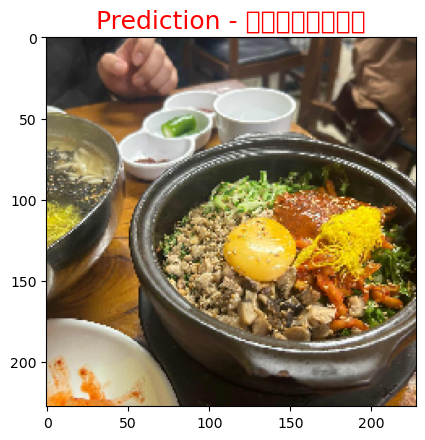

In [85]:
predict_image("./test/750_750_20230507065959_photo1_3959c8aba573.jpg", model)

1/1 [==============================] - 0s 37ms/step
햄버거


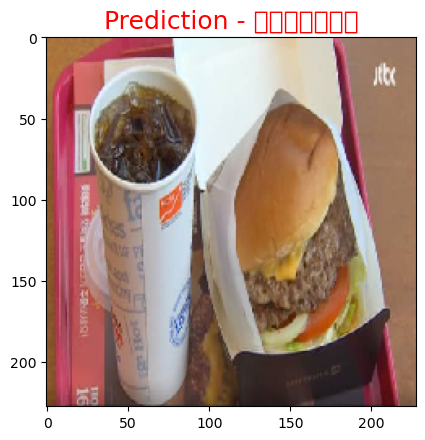

In [126]:
predict_image("./test/8129_22935_4813.jpg",model)

1/1 [==============================] - 0s 34ms/step
초밥


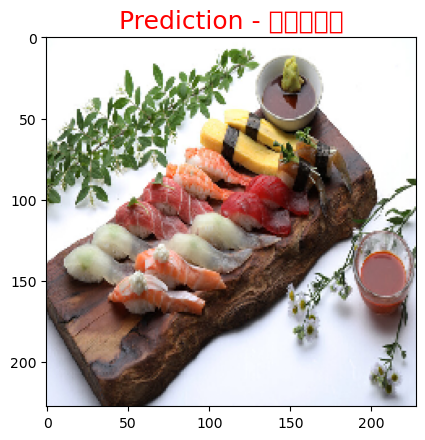

In [92]:
predict_image("./test/p1065620825291314_865_thum.jpg",model)

1/1 [==============================] - 0s 129ms/step
콩국수


/Users/jeongseong-yun/miniforge3/envs/krc/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 4367 (\N{HANGUL CHOSEONG KHIEUKH}) missing from current font.
  func(*args, **kwargs)
/Users/jeongseong-yun/miniforge3/envs/krc/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 4457 (\N{HANGUL JUNGSEONG O}) missing from current font.
  func(*args, **kwargs)
/Users/jeongseong-yun/miniforge3/envs/krc/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 4540 (\N{HANGUL JONGSEONG IEUNG}) missing from current font.
  func(*args, **kwargs)
/Users/jeongseong-yun/miniforge3/envs/krc/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 4352 (\N{HANGUL CHOSEONG KIYEOK}) missing from current font.
  func(*args, **kwargs)
/Users/jeongseong-yun/miniforge3/envs/krc/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 4462 (\N{HANGUL JUNGSEONG U}) missing from current font.
  func(*args, **kwargs)
/U

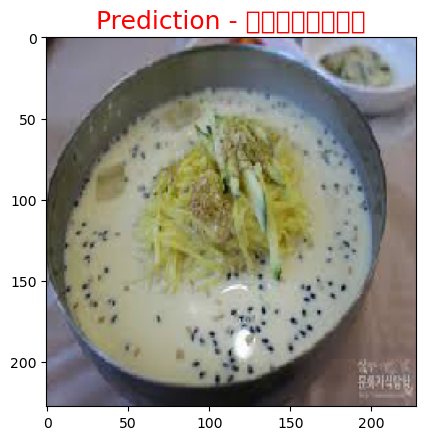

In [129]:
predict_image("./test/images (1).jpeg",model)